<a href="https://colab.research.google.com/github/FGalvao77/Criando-uma-rede-neural-artificial-com-o-PyTorch-para-classificacao-de-digitos/blob/main/Criando_uma_rede_neural_artificial_com_o_PyTorch_para_classifica%C3%A7%C3%A3o_de_d%C3%ADgitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Criando uma rede neural  artificial com o PyTorch para classificação de dígitos escritos a mão**

---



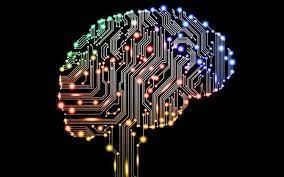

Vamos desenvolver um modelo de _Deep Learning_ usando `Pytorch`.

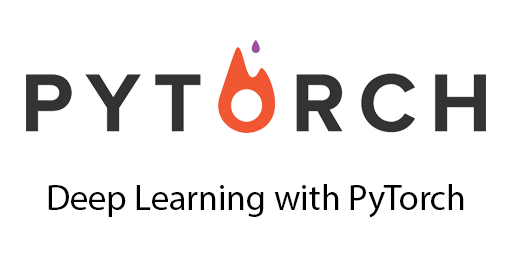

Realizaremos passo a passo as etapas de construção das redes neurais (RNs). O desafio é a classificação de números escritos a mão, portanto a nossa RNA demanda de recursos relacionados a **visão computacional**.

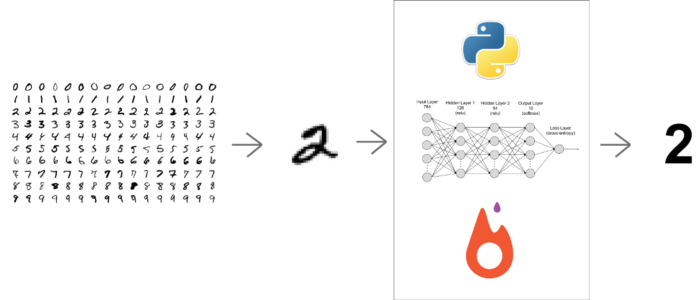

## **1. Introdução**

**O que é Pytorch?**

É uma biblioteca _open source_ para criar redes neurais que permite tanto o uso da **CPU** quanto da **GPU** para o treinamento do modelo. Por ser mais flexível que o `TensorFlow` e muito bem documentada, é ótima para se fazer pesquisas, na verdade, é o framework mais usado no meio acadêmico para construir RNs. ; )

Segue algumas das principais características do _framework_:

- Grafos computacionais dinâmicos;
- Ecossistema robusto, se integrando muito bem com outros frameworks voltados para a construção de modelos deep learning;
- Treinamento distribuído, sendo possível alocar várias GPUs para treinar o modelo e,
- Estrutura `“pythônica”`, ou seja, a sintaxe é bem parecida com a do _Python_.

**Hands-on learning**

Para cada etapa da construção da rede neural, iremos mostrar a aplicação em código e explicar o que está sendo feito, desta forma o processo de entedinento se torna mais fácil, uma aprendizagem prática.


## **2. Carregando as bibliotecas e o conjunto de dados**

In [2]:
# importando as bibliotecas necessárias
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

Pra esse desafio iremos utillizar um _dataset_ muito famoso, o [**MNIST**](http://yann.lecun.com/exdb/mnist/), aliás ele já vem incluso na biblioteca. Para baixá-lo basta importar diretamente de `import datasets.`

_**MNIST** é um conjunto de dados de imagens de dígitos escritos a mão, possui 60.000 exemplos para treino e 10.000 exemplos para teste._

O Torch trabalha com _tensores_, como se fosse uma "matriz". A diferença é que suas dimensões não estão limitadas, ou seja, podem ter dimensões 0 (**escalar**) quanto dimensão _n_.

Segue abaixo exemplo "vulgar" entre um elemento escalar, vetor, matriz e tensor.

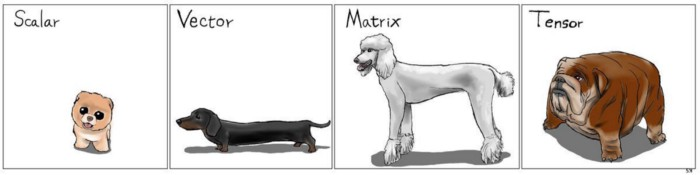

Sabendo-se disso, precisamos converter os dados para `tensor`.

In [4]:
# instanciando o conversor que realizará o processo de transformação da imagem para tensor
transform = transforms.ToTensor()

In [6]:
# instanciando o conjunto de dados para treino
train_set = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)

# criando um buffer para armazenar os dados por partes
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

In [7]:
# instanciando o conjunto de dados de validação
val_set = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)

# criando um buffer para armazenar os dados por partes
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

Agora explicar todo o processo realizado acima:

- a partir da `transforms.ToTensor()` definimos a variável **transform** como objeto a realizar à conversão dos dados do dataset para _tensor_.

- carregamos o set de treino na variável `train_set`. o primeiro argumento é o local onde será salvado o dataset, `train=True` determina que você quer carregar a parte reservada para treino (**85,7% dos dados**) e no último argumento, passamos a transformação definida anteriormente.

- por ser um dataset muito grande `(70.000 imagens)`, devemos criar um _buffer_ para otimizar a tarefa e acessá-lo em subgrupos menores. Para isso, definimos a variável `train_loader` que é um objeto iterável que nos fornece _lotes_ (`batchs`) de itens até que o set seja todo percorrido. Passamos como argumento o `train_set`, `batch_size=64` para que os subgrupos sejam de **64 itens** e `shuffle=True` que determina que iremos tomar os itens de forma aleatória, ou seja, um mesmo item pode estar presente em mais de um subgrupo.

- repetimos o mesmo processo para o set de validação.

In [19]:
# visualizando a dimensão dos objetos criados
len(train_set), len(train_loader), len(val_set), len(val_loader)

(60000, 938, 10000, 157)

In [18]:
# visualizando o tipo de objeto criado
type (train_set), type (train_loader), type (val_set), type (val_loader)

(torchvision.datasets.mnist.MNIST,
 torch.utils.data.dataloader.DataLoader,
 torchvision.datasets.mnist.MNIST,
 torch.utils.data.dataloader.DataLoader)

## **3. Explorando os dados**

Vamos inspecionar um dos itens do conjunto de dados para termos uma ideia de seu formato. Cada item possui uma imagem e uma etiqueta, este ultimo é o digito que a imagem representa.

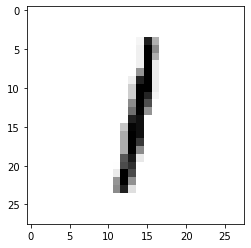

In [21]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

Analisando a dimensão do tensor imagem e do tensor etiqueta (um número de 0 a 9).

In [22]:
# visualizando as dimensões do tensor (imagem)
images[0].shape

torch.Size([1, 28, 28])

In [23]:
# visualizando as dimensões do tensor (etiqueta)
labels[0].shape

torch.Size([])

O tensor etiqueta não possui dimensão nenhuma por ser um elemento do tipo escalar.

Já o tensor imagem possui 3 dimensões. Por quê?

A primeira dimensão é o número de canais da nossa imagem. Como é uma imagem preto e branco, possui apenas um, que diz respeito a intensidade do preto em cada pixel. 

- Imagens coloridas costumam ter 3 canais (vermelho, verde e azul), ou conhecido como RGB (do inglês - red, green e blue).

Já as duas últimas dimensões representam a quantidade de pixels, nesse caso 28 x 28 = 784 pixels.

Sendo assim, para o PyTorch, cada imagem é um tensor de 28 x 28 com valores para cada elemento variando de 0 a 1 de forma contínua.

In [28]:
# visualizando o tensor da imagem "0"
images[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [29]:
# visualizando a etiquete do tensor "0"
labels[0]

tensor(1)

Podemos visualizar quais as etiquetas únicas presente no objeto.

In [30]:
# visualizando as etiquetas únicas presente
labels.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## **4. Construindo a Rede Neural**

Uma boa prática e muito comum, é construir uma classe para conter toda estrutura da nossa RNA. Essa modularizarão facilita adaptações futuras no nosso modelo. 

Pra nossa sorte, o PyTorch possui uma superclasse que auxilia nessa tarefa, a `nn.Module`.

Essa será a estrutura do nossa rede neural.

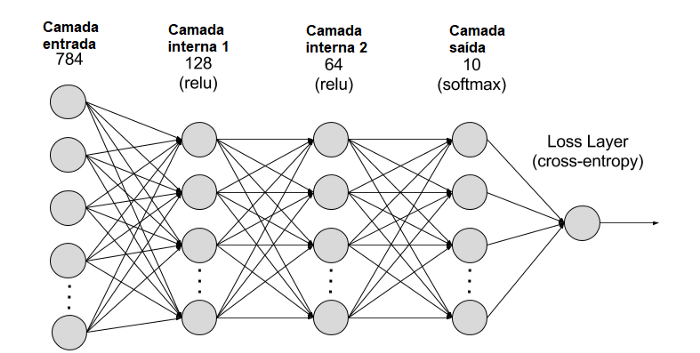

Na camada de entrada temos 28 x 28 = 784 neurônios, um para cada pixel da imagem. Esses neurônios irão receber o valor entre 0 e 1 de acordo com a intensidade do preto no pixel correspondente. 

Nas camadas internas 1 e 2, temos 128 e 64 neurônios, respectivamente, essa escolha foi arbitrária.

Na camada de saída temos 10 neurônios, isso é bem lógico, já que cada item de entrada poderá assumir pertencer somente as etiquetas 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, que totaliza 10 labels.

Utilizaremos como função de ativação a [`ReLU`](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)): 

- entrada → interna 1 e interna 1 → interna 2. Essa é uma função do seguinte formato: **f(y) = y**, se **y > 0**, caso contrário, **f(y) = 0**.

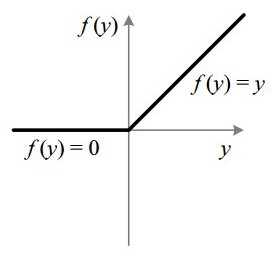

Por ser um problema de classificação, o tensor devolvido pela camada de saída (10 valores entre 0 e 1, correspondendo a probabilidade da imagem pertencer a uma label, segundo o modelo), e para essa análise de probabilidade aplicaremos a função [`LogSoftmax`](https://pytorch.org/docs/stable/nn.html?highlight=logsoftmax#torch.nn.LogSoftmax), que devolve um tensor com as mesmas dimensões da saída.

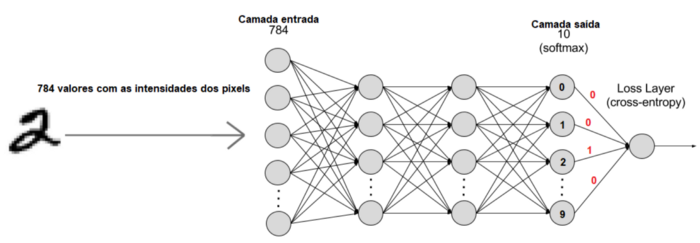

A partir deste tensor e da label (nesse caso é a etiquete pois ela define qual o digito que a imagem sendo analisada representa), aplicamos a função [`negative log-likelihood loss(NLLLoss)`](https://pytorch.org/docs/stable/nn.html#nllloss) e calculamos a **perda**. A lógica é a mesma do _erro quadrático médio(MSE)_, quanto mais próximo de zero, melhor.

Agora vamos instanciar a classe do `Modelo`.

In [32]:
# definindo a classe do modelo

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # camada de entrada de 28 * 28 = 784 neurônios que se ligam a 128
        self.linear1 = nn.Linear(28 * 28, 128)
        # primiera camada interna de 128 neurônios que se ligam a 64
        self.linear2 = nn.Linear(128, 64)
        # segunda camada interna de 64 neurônios que se ligam a 10
        self.linear3 = nn.Linear(64, 10)
        # para a camada de saida não e necessário definir, 
        # pois pegaremos o output da segunda camada interna

    def forward(self, x):
        # função de ativação da camada de entrada para a primeira camada interna
        x = F.relu(self.linear1(x))
        # função de ativação da primeira camada interna para a segunda camada interna
        x = F.relu(self.linear2(x))
        # função de ativação da segunda camada interna para a camada de saída, nesse caso f(x) = x
        x = self.linear3(x)
        # dados utilizados para calcular a perda
        return F.log_softmax(x, dim=1)

A função `forward(self, X)` nos retorna o tensor que será utilizado para calcular a perda. Isso será o resultado do modelo.

As funções que utilizamos são do `import torch.nn.functional as F`, funções especiais para trabalhar com tensores, e o tipo das camadas foram definidos a partir do `import nn`. 

Utilizamos camadas lineares por simplicidade. Para classificação de imagens, o ideal seria também utilizarmos camadas de **convolução 2D**.

Definindo a estrutura de treino do modelo. As principais etapas são:

- calcular a perda a partir da comparação entre as predições e as etiquetas (target) do subgrupo sendo analisado; 
- com a perda, calcular o gradiente em relação aos pesos e as bias e,
- a partir do gradiente e de uma regra de otimização, atualizar os pesos e as bias.

Para toda esse necessidade o PyTorch fornece as ferramentas para realização dos cálculos. 

**Autograd**

A partir dos grafos computacionais dinâmicos, por padrão o PyTorch armazena uma espécie de histórico das operações realizadas. Na imagem abaixo isso fica mais claro.

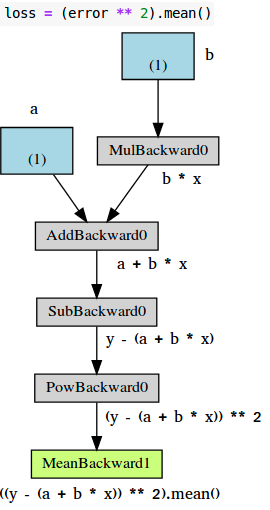

É possível calcular as derivadas parciais da **`loss = ((y - (a + b * x)) ** 2).mean( )`** em relação a `a` e `b` (caixas azuis) já que foi armazenado a “história” dessas variáveis.

Assim, calculamos o gradiente facilmente, pela regra da cadeia, da perda em relação aos pesos e bias. 

O PyTorch possui uma biblioteca que fará todo esse processo!

**Otimizador**

Você pode pensar em querer atualizar os pesos e as bias a partir de um loop, calculando cada elemento da seguinte forma: **`a = a - lr * grad`** (onde `lr` é a _taxa de aprendizado_ e `grad` é a _derivada parcial da perda_ em relação a `a`). Porém isso não é necessário. A partir do `import optim`, podemos escolher qual otimizador usar para fazer essas atualizações. 

Nesse caso vamos usar o _SGD (Stochastic Gradient Descent)_. Seus parâmetros principais são:

- `params`: iterável de parâmetros para serem otimizados (no nosso caso, pesos e bias);
- `lr`: taxa de aprendizado;
- `momentum`: valor entre 0 e 1, serve para evitar que o modelo encontre um falso mínimo global. Para uma boa RN, quanto maior a _lr_, menor deve ser o _momentum_.

A próxima etapa é definir a função de treino.

In [37]:
# definindo uma função de treinamento para o modelo

def model_training(model, train_loader, device):

    # define a regra de atualização dos pesos e da bias
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # timer para sabermos quanto tempo levou o treinamento
    start = time()

    # definindo o critério para calcular a perda
    criterion = nn.NLLLoss()
    # número de épocas que o algoritmo rodará
    epochs = 30
    # ativando o modo de treinamento do modelo
    model.train()

    for epoch in range(epochs):
        # inicialização da perda acumulada da epoch
        accumulated_loss = 0

        for images, labels in train_loader:

            # convertendo as imagens para  "vetores" de 28*28 casas para ficarem compatíveis com a camada de entrada
            images = images.view(images.shape[0], -1)
            # zerando os gradientes por conta do ciclo anterior
            optimizer.zero_grad()

            # colocando os dados no modelo
            output = model(images.to(device))
            # calculando a perda da epoch 
            instant_loss = criterion(output, labels.to(device))
            # back propagation a partir da perda
            instant_loss.backward()

            # atualizando os pesos e a bias
            optimizer.step()

            # atualização da perda acumulada
            accumulated_loss += instant_loss.item()

        else:
            # print("Epoch {} - Perda resultante: {}".format(epoch + 1, accumulated_loss / len(train_loader)))
            print(f'Epoch {epoch + 1} | Perda resultante: {accumulated_loss / len(train_loader)}')

    # print("\nTempo de treino (em minutos) =", (time() - start) / 60)
    print(f'\nTempo de treino (em minutos): {(time() - start) / 60}')

Explicando passa a passo o que está sendo feito:

1.  inicializamos o otimizador;
2.  a partir de ``model.train( )`, colocamos o modelo no modo treinamento;
3.  definimos quantas `epochs` queremos para treinar o modelo;
4.  em cada `epoch`, iteramos pelo `train loader` (lembrando que este é um objeto iterável) até que todo o set de treino seja percorrido;
5.  em cada iteração do `train_loader` calculamos a perda instantânea, que representa a perda calculada apenas em relação aos _64 itens atuais_. Para calcular a perda da **epoch**, deve-se tomar a _média das perdas instantâneas_;
6.  a partir de perda instantanea, `instant_loss.backward()`, calculamos o gradiente da perda instantânea;
7. com as derivadas parciais e chamando otimizador `optimizer.step( )`, atualizamos os pesos e bias;
8.  os passos 5, 6 e 7 são repetidos até que todo o `train_set` seja percorrido e,
9.  volta ao passo 4 até chegar a ultima **epoch**.

Vamos agora definir a função de validação. 

In [39]:
# criando uma função para validação do modelo

def validation(model, val_loader, device):
    correct, total = 0, 0

    for images, labels in val_loader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)

            # desativar o autograd para acelerar a validação
            # grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                # output do modelo em escala logarítmica
                logps = model(img.to(device))
            
            # converte output para escala normal (lembrando que é um tensor)
            ps = torch.exp(logps)
            probab = list(ps.cpu().numpy()[0])
            # converte o tensor em um número, no caso, o número que o modelo previu como correto
            pred_label = probab.index(max(probab))
            correct_label = labels.numpy()[i]

            # compara a previsão com o valor correto
            if (correct_label == pred_label):
                correct += 1

            total += 1

    print(f'Total de imagens testadas = {total}')
    print(f'\nPrecisão do modelo = {correct * 100 / total}')

## **5. Iniciando a rede neural**

In [43]:
# instanciando o modelo
modelo = Model()

# ativando o modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # modelo rodará na GPU se possível
modelo.to(device)   # visuzalizando os parâmetros do modelo

Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

Colocamos para rodar na GPU(se possível) para demonstrar essa funcionalidade.

**Treinando o modelo.**

In [44]:
# utilizando a função criada "model_training" e aplicando o treinamento do modelo
# com os dados de treino "train_loader"
model_training(modelo, train_loader, device)

Epoch 1 | Perda resultante: 1.154947034458616
Epoch 2 | Perda resultante: 0.3794419694302687
Epoch 3 | Perda resultante: 0.3125557661501329
Epoch 4 | Perda resultante: 0.2737751661984524
Epoch 5 | Perda resultante: 0.24392432686108262
Epoch 6 | Perda resultante: 0.21817531327861966
Epoch 7 | Perda resultante: 0.19698991097493976
Epoch 8 | Perda resultante: 0.17910861904258285
Epoch 9 | Perda resultante: 0.16377005059081418
Epoch 10 | Perda resultante: 0.14983684535044978
Epoch 11 | Perda resultante: 0.13810306615523818
Epoch 12 | Perda resultante: 0.1279271184218559
Epoch 13 | Perda resultante: 0.11895579060039191
Epoch 14 | Perda resultante: 0.11121004425596867
Epoch 15 | Perda resultante: 0.10398338546952618
Epoch 16 | Perda resultante: 0.0976696512145576
Epoch 17 | Perda resultante: 0.09170052224396864
Epoch 18 | Perda resultante: 0.08645814385658293
Epoch 19 | Perda resultante: 0.08130422198741849
Epoch 20 | Perda resultante: 0.07716808237705323
Epoch 21 | Perda resultante: 0.07316

**Validando o Modelo.**

In [45]:
# validando a performance do modelo com a função criada "validation"
validation(modelo, val_loader, device)

Total de imagens testadas = 10000

Precisão do modelo = 97.64


## **6. Salvando o modelo**

Depois de todo esse trabalho, iremos salvar a evolução da RN.

In [47]:
 # salvando o modelo
torch.save(modelo.state_dict(), './meu_modelo.pt')

# carregando o modelo
model_loaded = Model()

model_loaded.load_state_dict(torch.load('./meu_modelo.pt'))
model_loaded.eval()
model_loaded.to(device)

Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

**Bônus**

Vamos visualizar uma predição aleatória do set de validação, porém antes, criaremos uma função para plotar graficamente o label do objeto e sua probabilidade de pertencer a este mesmo.

In [56]:
# criando uma função para plotagem da imagem do label e a probabilidade do mesmo pertencer a este label

def view_pred(img, ps):

    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')

    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))

    ax2.set_title('Probabilidade')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Número previsto = 2



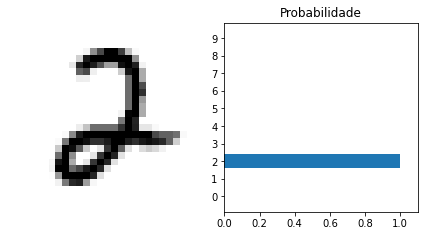

In [59]:
# sorteando aleatoriamente uma iamgem e visualizando-a e sua probabilidade de pertencer ao label em questão
images, labels = next(iter(val_loader))

img = images[0].view(1, 784)

with torch.no_grad():
    logps = modelo(img.to(device))

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])

print(f'Número previsto = {probab.index(max(probab))}\n')
view_pred(img.view(1, 28, 28), ps)

## **7. Considerações finais**

Construímos uma base boa para conseguirmos treinar Redes Neurais mais complexas utilizando o PyTorch sem grandes dificuldades. 

Apresentamos as principais características da biblioteca mas sem entrar muito nos detalhes já que nosso foco foi montar a rede em si.

Existem diversos pacotes para facilitar o trabalho com os diferentes tipos de dados, sendo eles:

- para imagens: `Pillow` e `OpenCV`.
- para áudio: `scipy` e `libroso`.
- para texto: `Cython`, `NLTK` ou `SpaCy`.

Independente do tipo dos dados, depois de carregados e convertidos para tensores, o processo para montar a RN é bem similar (usando as camadas, otimizadores e função perda mais adequados) com o que fizemos aqui.

Outra ferramenta interessante e bem integrada com PyTorch é o [TensorBoard](https://www.tensorflow.org/tensorboard?hl=pt-br), que permite visualizar, a partir de gráficos, como o modelo está evoluindo. 

Por fim, esperamos ter tirado um pouco desse misticismo que existe em volta da “buzzword” Machine Learning e mostrar que, com as ferramentas que temos a nosso dispor, qualquer um pode montar uma rede neural do zero.

Numa abordagem quase que de tentativa e erro para determinar a estrutura do nosso modelo, conseguimos um preditor com uma taxa de acerto de 97% (o estado da arte para esse problema é 99,79%). Claro que apenas reproduzimos técnicas existente há décadas e, se você quiser se aventurar de verdade por esse mundo, montando modelos com alto grau de complexidade, há uma longa jornada de aprendizado a ser percorrida.

## **8. Referências**

1. [Pytorch documentation](https://pytorch.org/docs/stable/index.html)
2. [Pytorch - Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
3. [CNN with Pytorch for MNIST](https://www.kaggle.com/sdelecourt/cnn-with-pytorch-for-mnist)
4. [Pytorch git examples](https://github.com/pytorch/examples/blob/master/mnist/main.py)
5. [PyTorch for Deep Learning: A Quick Guide for Starters](https://towardsdatascience.com/pytorch-for-deep-learning-a-quick-guide-for-starters-5b60d2dbb564)
6. [Understanding PyTorch with an example: a step-by-step tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e)

## **9. Base de conhecimento**

- Redes Neurais | Teoria
 - _[A metalinguagem de um post sobre a abstração de como raciocinamos](https://medium.com/turing-talks/turing-talks-19-modelos-de-predi%C3%A7%C3%A3o-redes-neurais-1f165583a927)_

- Redes Neurais | Teoria #2
    - _[Um mergulho mais profundo no aprendizado das Redes Neurais](https://medium.com/turing-talks/turing-talks-21-modelos-de-predi%C3%A7%C3%A3o-redes-neurais-parte-2-b0c2c33ee339)_

- Redes Neurais | Teoria #3
    - _[Um verdadeiro hands on em redes neurais](https://medium.com/turing-talks/turing-talks-22-modelos-de-predi%C3%A7%C3%A3o-redes-neurais-parte-3-9c5d5d0c60e7)_

In [60]:
from IPython.display import YouTubeVideo

- Segue uma série de vídeos sobre `Redes Neurais Artificiais`.



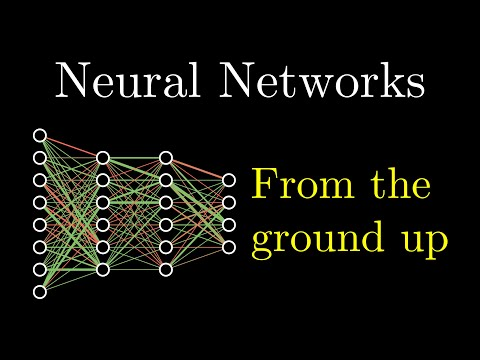

In [61]:
YouTubeVideo("aircAruvnKk", width=640)

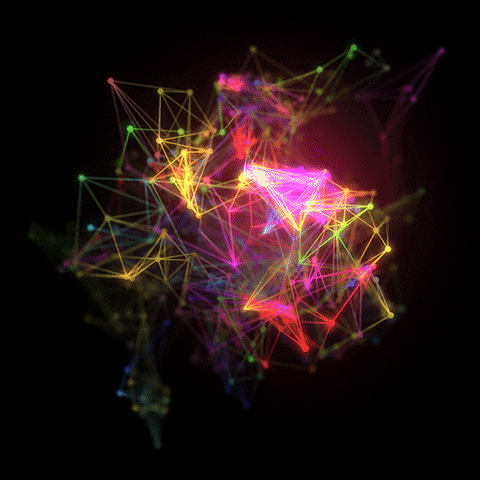